# Processing Sequences Using RNNs and CNNs

No GPU was detected.


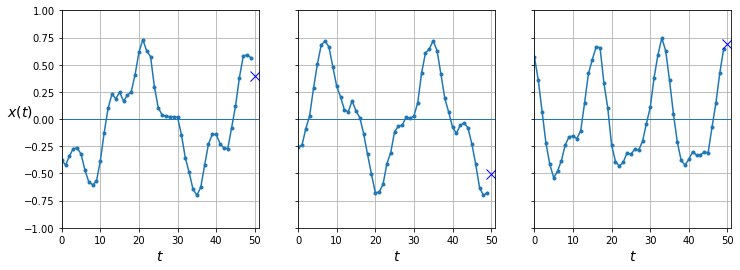

In [1]:
# FIXME: meke autocompletion working again
%config Completer.use_jedi = False

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

if not physical_devices:
    print("No GPU was detected.")
else:
    # https://stackoverflow.com/a/60699372
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
from tensorflow import keras

# Set RNG state
np.random.seed(42)
tf.random.set_seed(42)


def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    # wave 1
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    # add wave 2
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    # add noise
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)


# Generate a dataset of fixed length sequences
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

# Split the dataset into training, validation and test parts
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    
    if x_label:
        plt.xlabel(x_label, fontsize=14)
    
    if y_label:
        plt.ylabel(y_label, fontsize=14, rotation=0)
    
    plt.grid(True)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


# Plot few series from the validation set
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)$" if col == 0 else None))
    
plt.show()

## Baseline predictors

### Naive predictor
The simplest baseline benchmark is a predictor that predicts the last observed value.

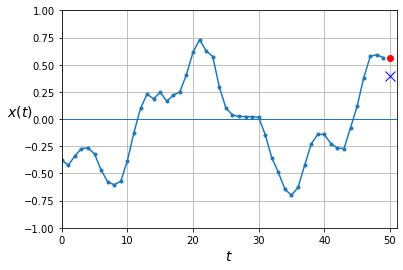

In [2]:
# Naive prediction
y_pred = X_valid[:, -1]

# Plot the prediction and actual value
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [3]:
# Validation accuracy of the Naive predictor
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

### Linear predictor
Another benchmark is a simple linear regressor trained for couple of epochs.

In [4]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build simple univariate linear model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")

# Train and validate the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Show the validation set accuracy
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0062

0.004168087150901556

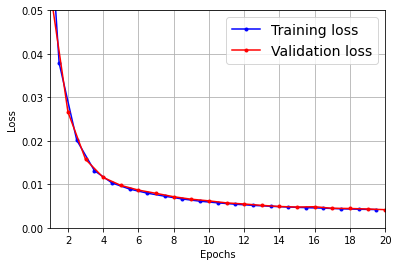

In [5]:
import matplotlib as mpl

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# Plot learning curves for the linear regressor
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

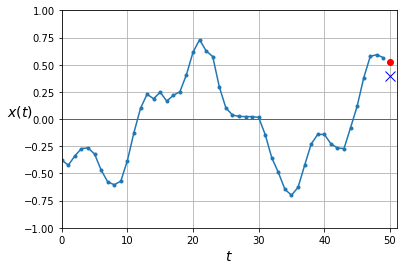

In [6]:
# Make a prediction of the validation set
y_pred = model.predict(X_valid)

# Plot one series from the validation set
#  - and compare target and predicted values
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Implementing a Simple RNN

In [7]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build simple RNN with single neuron
#  - input shape is `None` because recurrent neurons (layers) accept arbitrary number of (repeated) inputs
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

# Train and validate the model
#  - RNNs are trained using *Backpropagation Through Time (BPTT)*
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Show validation set accuracy
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0117 - val_loss: 0.

0.010881561785936356

Notice that with single neuron RNN we've not yet beaten the linear regressor. However, compared to the linear model, this RNN uses only 3 parameters! Those are the weights of the input at particular time, the hidden state (which in this case is simply neuron's feedback from previous timestamp) and the bias term.

So the first advantage of this approach is model's compactness. Moreover, our RNN was extremely simple and there's a good chance we can do better without blowing the model up too much.

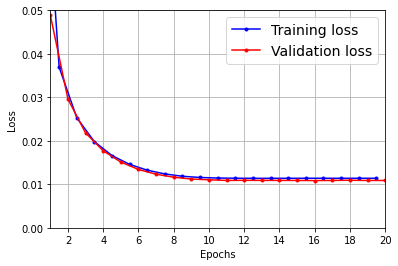

In [8]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

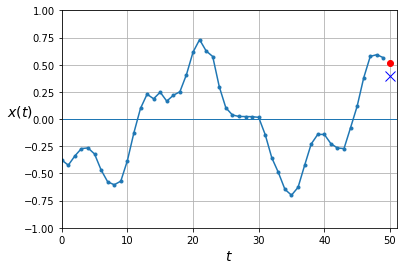

In [9]:
y_pred = model.predict(X_valid)

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [10]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build multi-layer RNN
#  - by default RNN layers return just their last output, `return_sequences` must be enabled to pass all outputs to upper recurrent layers
#  - in this task we care only about the last output (predicted value one step ahead), so the last layer doesn't have to return full sequence
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.compile(loss="mse", optimizer="adam")

# Train and validate the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Evaluate the model on the validation set
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 7s 26ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0035 - val_lo

0.0029105644207447767

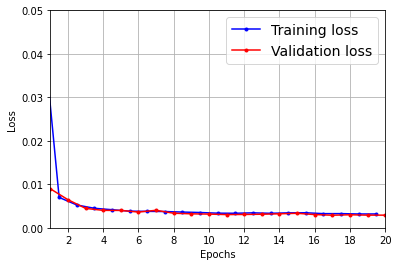

In [11]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

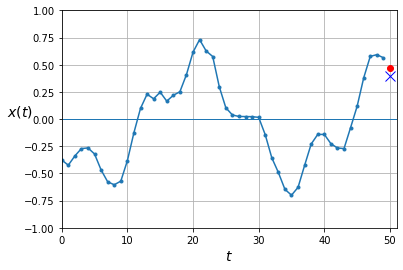

In [12]:
y_pred = model.predict(X_valid)

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Because our task only asks for the very last value (the prediction one step ahead the input series), we could replace the last recurrent layer by a simple single neuron dense layer. This can be justified because all the information that must be carried over time frames is probably captured in the first two layers and we force the single neuron output layer just because of the univariate task. Moreover, we can use any activation function we want in the dense layer, whereas `SimpleRNN` neurns use *tanh*.

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

# Build a model with two recurrent layers and dense univariate output
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")

# Train and validate the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Evaluate the model on the validation set
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 5s 19ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0029 - val_lo

0.002623624401167035

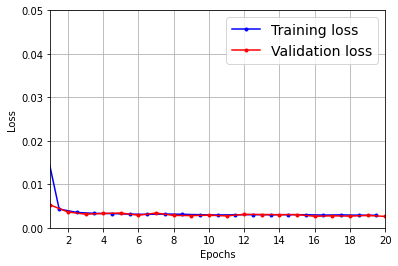

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

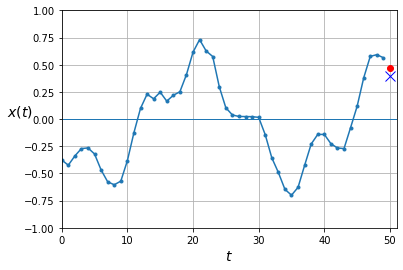

In [15]:
y_pred = model.predict(X_valid)

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

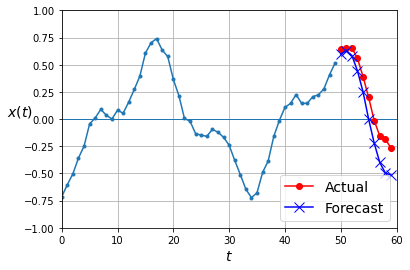

In [16]:
# Reset RNG state
#  - not 42, as it would give the first series in the train set
np.random.seed(43)

def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps, ahead = X.shape[1], Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


# Generate new time series dataset
series = generate_time_series(1, n_steps + 10)

# Make consecutieve predictions
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

# Take final predictions for n steps ahead
Y_pred = X[:, n_steps:]

# Plot the forecast
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [17]:
# Reset RNG state
np.random.seed(42)

n_steps = 50
n_steps_ahead = 10

# Generate and split sequences with additional 10 frames
series = generate_time_series(10000, n_steps + n_steps_ahead)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -n_steps_ahead:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_steps_ahead:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -n_steps_ahead:, 0]

### Predict next N values one by one

In [18]:
X = X_valid
for step_ahead in range(n_steps_ahead):
    # Make single forecast
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    # Pretend we've observed this prediction
    X = np.concatenate([X, y_pred_one], axis=1)

# Collect predictions for the whole validation batch
#  - i.e. for each instance a vector of 10 future values
Y_pred = X[:, n_steps:, 0]
Y_pred.shape

(2000, 10)

In [19]:
# Evaluate the validation error
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.02751084

In [20]:
# Compare the prediction with the Naive predictor
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [21]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build simple linear model predicting 10 values
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])
model.compile(loss="mse", optimizer="adam")

# Train and validate the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0222

### RNN predicting next N values at once

In [22]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build RNN predicting 10 values ahead at once
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])
model.compile(loss="mse", optimizer="adam")

# Train and validate the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0118 - val_lo

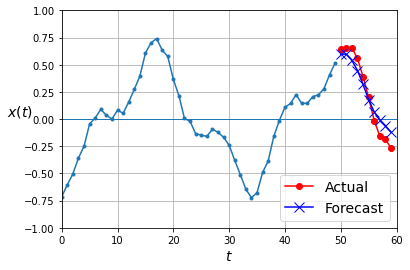

In [23]:
# Reset RNG state
np.random.seed(43)

# Generate a series and make a prediction of 10 values ahead
series = generate_time_series(1, 50 + n_steps_ahead)
X_new, Y_new = series[:, :50, :], series[:, -n_steps_ahead:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

# Show the time series and prediction
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### RNN predicting next N steps at each time step
By predicting a vector of values at each time frame, we propagate more gradients from the the loss function to the intermediate recurrent layers which helps the learning process.

In [24]:
# Reset RNG state
np.random.seed(42)

n_steps = 50
n_steps_ahead = 10

# Generate (and split) a dataset of time series with 10 additional frames
series = generate_time_series(10000, n_steps + n_steps_ahead)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# Construct targets
#  - here we add 10 previes trainng inputs as targets for the next step (sliding forward in time)
#  - this is actually fine becase at no point we propagate a future value, so prediction is learned solely based on the past (i.e. it's causal)
Y = np.empty((10000, n_steps, n_steps_ahead))
for step_ahead in range(1, n_steps_ahead + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [25]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build RNN predicting a vector of 10 values at each frame
#  - notice that the output dense layer is wrapped in `TimeDistributed` which applies the layer at each frame of the time-unfolded RNN
#  - actually in this case it's not necessary because a dense layer does this implicitly (for a 3D input tensor)
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

# Compile the model with custom metric
#  - Although we predict 10 values at each point, in our task we care just about the final output
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])

# Train and validate the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 20ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0366 - val_last_time_step_mse: 0.0264
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0338 - last_time_step_mse: 0.0228 - val_loss: 0.0362 - val_last_time_step_mse: 0.0242
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0304 - last_time_step_mse: 0.0195 - val_loss: 0.0278 - val_last_time_step_mse: 0.0157
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0276 - last_time_step_mse: 0.0161 - val_loss: 0.0274 - val_last_time_step_mse: 0.0178
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0261 - last_time_step_mse: 0.0139 - val_loss: 0.0254 - val_last_time_step_mse: 0.0126
Epoch 7/20
219/219 [==

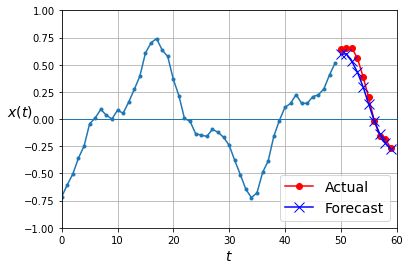

In [26]:
# Reset RNG state
np.random.seed(43)

# Generate new series and make a prediction
series = generate_time_series(1, 50 + n_steps_ahead)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

# Show the time series and prediction
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Deep RNN with Batch Normalization

In [27]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# RNN with batch level normalization layers
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Train and validate the model
#  - notice that classical BN does not help much here
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 30ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [==

## Deep RNNs with Layer Normalization
Another approach to normalization is to apply scaling on the layer level. I.e. independently per each instance before applying the activation function.

In [28]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        # Activation is disabled because we want to apply it manually after normalization
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    def call(self, inputs, states):
        # Here we can ignore the second output (new states) because in our case it the same as outputs
        outputs, _ = self.simple_rnn_cell(inputs, states)
        # Manually apply normalization and activation function
        norm_outputs = self.activation(self.layer_norm(outputs))
        # Return normalized outputs and new states (in this case the same as outputs)
        return norm_outputs, [norm_outputs]

# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# RNN with normalization applied on the layer level
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Train and validate the model
#  - it should work better than BN
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 39ms/step - loss: 0.2887 - last_time_step_mse: 0.2855 - val_loss: 0.0755 - val_last_time_step_mse: 0.0713
Epoch 2/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0701 - last_time_step_mse: 0.0617 - val_loss: 0.0588 - val_last_time_step_mse: 0.0472
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0574 - last_time_step_mse: 0.0462 - val_loss: 0.0508 - val_last_time_step_mse: 0.0373
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0498 - last_time_step_mse: 0.0366 - val_loss: 0.0452 - val_last_time_step_mse: 0.0311
Epoch 5/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0443 - last_time_step_mse: 0.0302 - val_loss: 0.0411 - val_last_time_step_mse: 0.0267
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0401 - last_time_step_mse: 0.0254 - val_loss: 0.0363 - val_last_time_step_mse: 0.0210
Epoch 7/20
219/219 [=

## Creating a Custom RNN Class

In [29]:
class MyRNN(keras.layers.Layer):
    
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        # Use cell's state initializer or a default one implemented by this class
        self.get_initial_state = getattr(self.cell, "get_initial_state", self.fallback_initial_state)
    
    def fallback_initial_state(self, inputs):
        """Default state initializer used if cells don't implement one."""
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    
    @tf.function
    def call(self, inputs):
        # Inputs have shape `[batch_size, n_steps, n_features]`
        n_steps = tf.shape(inputs)[1]
        
        # Initialize states
        states = self.get_initial_state(inputs)
        
        # Allocate a collection recording the history of produced sequences
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        
        # Allocate a tensor for layer outputs
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        
        for step in tf.range(n_steps):
            # Apply the cell to an input batch for current time frame
            #  - produce current frame's outputs and new states
            outputs, states = self.cell(inputs[:, step], states)
            
            # Record outputs from this time frame in the sequence history
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        
        # Return outputs either from all time frames of from the final one
        return sequences.stack() if self.return_sequences else outputs


# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# RNN with custom layers
model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Train and validate the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 45ms/step - loss: 0.3561 - last_time_step_mse: 0.3517 - val_loss: 0.0769 - val_last_time_step_mse: 0.0716
Epoch 2/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0723 - last_time_step_mse: 0.0647 - val_loss: 0.0634 - val_last_time_step_mse: 0.0564
Epoch 3/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0614 - last_time_step_mse: 0.0543 - val_loss: 0.0539 - val_last_time_step_mse: 0.0428
Epoch 4/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0525 - last_time_step_mse: 0.0410 - val_loss: 0.0477 - val_last_time_step_mse: 0.0355
Epoch 5/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0466 - last_time_step_mse: 0.0347 - val_loss: 0.0437 - val_last_time_step_mse: 0.0319
Epoch 6/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0428 - last_time_step_mse: 0.0306 - val_loss: 0.0399 - val_last_time_step_mse: 0.0271
Epoch 7/20
219/219 [=

## Long Short-Term Memory (LSTM)
The motivation to use LSTMs is the following problem with deep RNNs (note that even a RNN with few recurrent layers can become deep when unfolded in time): When unfolded in time, neurons of a recurrent layer are "duplicated" which means that their weights are shared/reused during BPTT. Therefore, if some singnal starts fading away at some point, this effect is multiplied (due to weight sharing) and very soon this information is completely lost - forgotten.

The main idea behind LSTMs is not to have just single hidden state $\mathbf{h}_{(t)}$ (*short-term memory*) that is fed back to a recurrent neuron the next time frame, but to add an additional state $\mathbf{c}_{(t)}$ representing a *long-term memory*.

The overall architecture of a LSTM cell consists of multiple components:

**State**:
* *long-term memory* $\mathbf{c}_{(t - 1)}$ - at each step part of the memory is forgotten (controlled by the *forget gate*) and part is gained (*input gate*), resulting in new $\mathbf{c}_{(t)}$
* *short-term memory* $\mathbf{h}_{(t - 1)}$ - is essentially a filtering of the long-term memory controlled by the *output gate*, it serves as both the output $\mathbf{y}_{(t)}$ and hidden state $\mathbf{h}_{(t)}$

**Gates and controllers**:
* *forget gate* controlled by $\mathbf{f}_{(t)}$ - uses a logistic (outputs values between 0 and 1) applied to a combination of inputs $\mathbf{x}_{(t)}$ and previous state $\mathbf{h}_{(t - 1)}$ to filter the long-term state
* *input gate* - is basically a standard recurrent cell $\mathbf{g}_{(t)}$ (with *tanh* activation) that is controlled by an input controller $\mathbf{i}_{(t)}$ (analogous to $\mathbf{r}_{(t)}$), the final ouptut serves as new addition to the long-term state
* *output gate* controlled by $\mathbf{o}_{(t)}$ - also analogous to $\mathbf{f}_{(t)}$ but for the cell output as mentioned above

The LSTM dynamics for single inputs instance looks like this (batch input is similar):
$$
\begin{equation}
\begin{aligned}
  \mathbf{i}_{(t)} &= \sigma(\mathbf{W}_{xi}^T \mathbf{x}_{(t)} + \mathbf{W}_{hi}^T \mathbf{h}_{(t - 1)} + \mathbf{b}_i) \\
  \mathbf{f}_{(t)} &= \sigma(\mathbf{W}_{xf}^T \mathbf{x}_{(t)} + \mathbf{W}_{hf}^T \mathbf{h}_{(t - 1)} + \mathbf{b}_f) \\
  \mathbf{o}_{(t)} &= \sigma(\mathbf{W}_{xo}^T \mathbf{x}_{(t)} + \mathbf{W}_{ho}^T \mathbf{h}_{(t - 1)} + \mathbf{b}_o) \\
  \mathbf{g}_{(t)} &= \tanh(\mathbf{W}_{xg}^T \mathbf{x}_{(t)} + \mathbf{W}_{hg}^T \mathbf{h}_{(t - 1)} + \mathbf{b}_g) \\ 
  \mathbf{c}_{(t)} &= \mathbf{f}_{(t)} \otimes \mathbf{c}_{(t - 1)} + \mathbf{i}_{(t)} \otimes \mathbf{g}_{(t)} \\
  \mathbf{y}_{(t)} &= \mathbf{h}_{(t)} = \mathbf{o}_{(t)} \otimes \tanh(\mathbf{c}_{(t)})
\end{aligned}
\end{equation}
$$

Where $\mathbf{W}$ and $\mathbf{b}$ are respective weights and biases.

In [30]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# RNN using LSTM layers
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Train and validate the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 38ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=

In [31]:
# Evaluate the model on the validation set
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788681253790855, 0.008560795336961746]

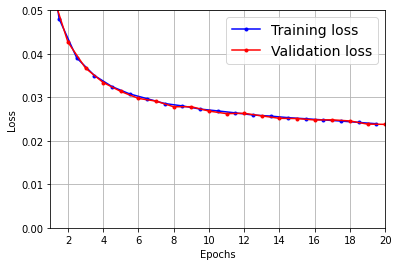

In [32]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

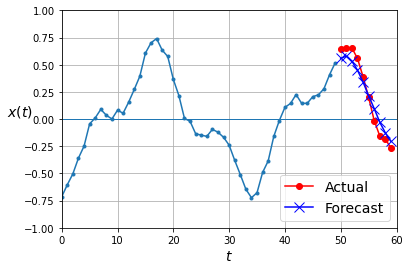

In [33]:
# Reset RNG state
np.random.seed(43)

# Make a prediction on new series
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

# Show the prediction
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Gated Recurrent Unit (GRU)
GRUs can be viewed as simplified LTSMs where
* both states are merged into single $\mathbf{h}_{(t)}$
* before adding new memory, the old is erased - this is achieved by having just single controller $\mathbf{z}_{(t)}$ replacing both the forget and input gates (whenever the "forget" path is open, the "input" path is closed)
* there's no output gate, however, there's new gate controller $\mathbf{r}_{(t)}$ which filters which part of the previous state is shown to the main layer $\mathbf{g}_{(t)}$

The overall GRU dynamics is as follows:
$$
\begin{equation}
\begin{aligned}
  \mathbf{z}_{(t)} &= \sigma(\mathbf{W}_{xz}^T \mathbf{x}_{(t)} + \mathbf{W}_{hz}^T \mathbf{h}_{(t - 1)} + \mathbf{b}_z) \\
  \mathbf{r}_{(t)} &= \sigma(\mathbf{W}_{xr}^T \mathbf{x}_{(t)} + \mathbf{W}_{hr}^T \mathbf{h}_{(t - 1)} + \mathbf{b}_r) \\
  \mathbf{g}_{(t)} &= \tanh(\mathbf{W}_{xg}^T \mathbf{x}_{(t)} + \mathbf{W}_{hg}^T (\mathbf{r}_{(t)} \otimes \mathbf{h}_{(t - 1)}) + \mathbf{b}_g) \\ 
  \mathbf{h}_{(t)} &= \mathbf{z}_{(t)} \otimes \mathbf{h}_{(t - 1)} + (1 - \mathbf{z}_{(t)}) \otimes \mathbf{g}_{(t)}
\end{aligned}
\end{equation}
$$

In [34]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# RNN with GRU layers
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Train and validate the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 41ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=

In [35]:
# Evaluate the model on the validation set
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262809693813324]

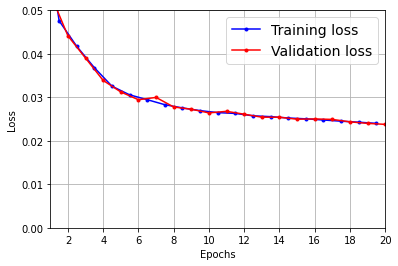

In [36]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

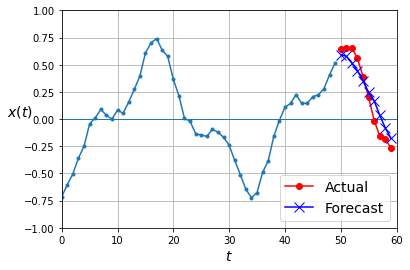

In [37]:
# Reset RNG state
np.random.seed(43)

# Make a prediction on new series
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

# Show the prediction
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences
One problem with stacking recurrent layers is that the network is inherently sequential (stateful) and impossible to parallelize. Contrary to that, a filter of a 1D convolution (or any other in fact) has to see just part of the inputs at once. For Also it is good to sub-sample the inputs before applying a recurrent layer and thus forece/help it to focus on larger patterns (to see and learn the bigger picture). Finally, conv. layers deal a bit better with the unstable gradient problem (exploding/vanishing).

In [38]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Sequence to vector RNN which starts with a 1D conv. layer which sub-samples the inputs
#  - note: sub-sampling happens due to combination of stride of 2 with valid padding
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Train and validate the model
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 9s 26ms/step - loss: 0.0908 - last_time_step_mse: 0.0845 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0437 - last_time_step_mse: 0.0357 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0356 - last_time_step_mse: 0.0282 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0293 - last_time_step_mse: 0.0201 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0256 - last_time_step_mse: 0.0152 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0239 - last_time_step_mse: 0.0129 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [==

### WaveNet
*WaveNet* is a particular architecture of a fully convolutional network which uses a stack of 1D convolutional layers with *causal* padding and doubling *dilation rate*. Let's start with a simplified version and follow up with the original one.

In [40]:
from functools import partial

# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build a simplified WaveNet
Conv1DLayer = partial(keras.layers.Conv1D, filters=20, kernel_size=2, padding="causal", activation="relu")

inputs = [keras.layers.InputLayer(input_shape=[None, 1])]
hidden = [Conv1DLayer(dilation_rate=rate) for rate in (1, 2, 4, 8) * 2]
outputs = [keras.layers.Conv1D(filters=10, kernel_size=1)]

model = keras.models.Sequential(inputs + hidden + outputs)
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Train and validate the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0981 - last_time_step_mse: 0.0891 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0340 - last_time_step_mse: 0.0212 - val_loss: 0.0295 - val_last_time_step_mse: 0.0167
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0291 - last_time_step_mse: 0.0163 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0265 - last_time_step_mse: 0.0141 - val_loss: 0.0255 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0251 - last_time_step_mse: 0.0129 - val_loss: 0.0245 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0243 - last_time_step_mse: 0.0122 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [====

Here is the original WaveNet defined in the paper: it uses *Gated Activation Units* instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences

In [41]:
# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


class GatedActivationUnit(keras.layers.Layer):
    
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

    def call(self, inputs):
        # No. filters is half the output dimension
        # - this is due to the fact that the signal to this unit comes from a 1D conv layer with doubled filters (in the residual block)
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

    
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    """
    WaveNet residual block composed of:
    
     1. 1D conv layer of 2n filters, kernel of size 2, causal padding and given dilation rate
     2. Gated Activation Unit
     3. 1D conv layer of n filters and kernel of size 1
    
    :returns: (outputs + inputs, outputs)
    """
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal", dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z


# Model hyperparameters
#  - scaled a bit down compared to the paper
n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 10  # 256 in the paper

# Input layer
inputs = keras.layers.Input(shape=[None, 1])

# Diletion rates for all hidden 1D conv layers
dilation_rates = [2**i for i in range(n_layers_per_block)] * n_blocks

# Hidden layers including skip connections
#  - build out of WaveNet residual blocks with Gated Activation Units
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in dilation_rates:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

# Combine all the skip connections and follow with final 1D conv layer
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)

# Output layer
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

# Compose and compile the model
model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Train and validate the model for just few epochs
history = model.fit(X_train, Y_train, epochs=2, validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 5s 18ms/step - loss: 0.1387 - last_time_step_mse: 0.1347 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 6s 26ms/step - loss: 0.1222 - last_time_step_mse: 0.1161 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


## Exercises

### SketchRNN Dataset

In [43]:
from pathlib import Path

# Download the dataset
dataset_file = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(
    dataset_file,
    f"http://download.tensorflow.org/data/{dataset_file}",
    cache_subdir="datasets/quickdraw",
    extract=True,
)

# Define paths to the training and validation files
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

# Read a list of train and test classes

with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

# Check that both splits define the same set of classes and get their names (lowercase)
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

len(class_names)

345

In [44]:
# Define features in the TFRecord Examples
feature_descriptions = {
    "ink": tf.io.VarLenFeature(dtype=tf.float32),
    "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
    "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
}


def parse(data_batch):
    # Deserialize the TFRecord Examples
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    
    # Process the sketches
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    
    # Extract the lengths (point counts in sketches) and class indices
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    
    return sketches, lengths, labels


def quickdraw_dataset(
    filepaths,
    batch_size=32,
    shuffle_buffer_size=None,
    n_parse_threads=5,
    n_read_threads=5,
    cache=False,
):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    dataset = dataset.cache() if cache else dataset
    dataset = dataset.shuffle(shuffle_buffer_size) if shuffle_buffer_size else dataset
    return dataset.batch(batch_size).map(parse, num_parallel_calls=n_parse_threads).prefetch(1)


# Pre-process all splits of the quickdraw datasets
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

# Peek the data
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.08627451  0.11764706  0.        ]
  [-0.01176471  0.16806725  0.        ]
  [ 0.02352941  0.07563025  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.04705882 -0.06696428  0.        ]
  [-0.09019607 -0.07142857  0.        ]
  [-0.0862745  -0.04464286  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [ 0.00784314  0.11320752  0.        ]
  ...
  [ 0.11764708  0.01886791  0.        ]
  [-0.03529412  0.12264156  0.        ]
  [-0.19215688  0.33962262  1.        ]]

 ...

 [[-0.21276593 -0.01960784  0.        ]
  [-0.31382978  0.00784314  0.        ]
  [-0.37234044  0.13725491  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

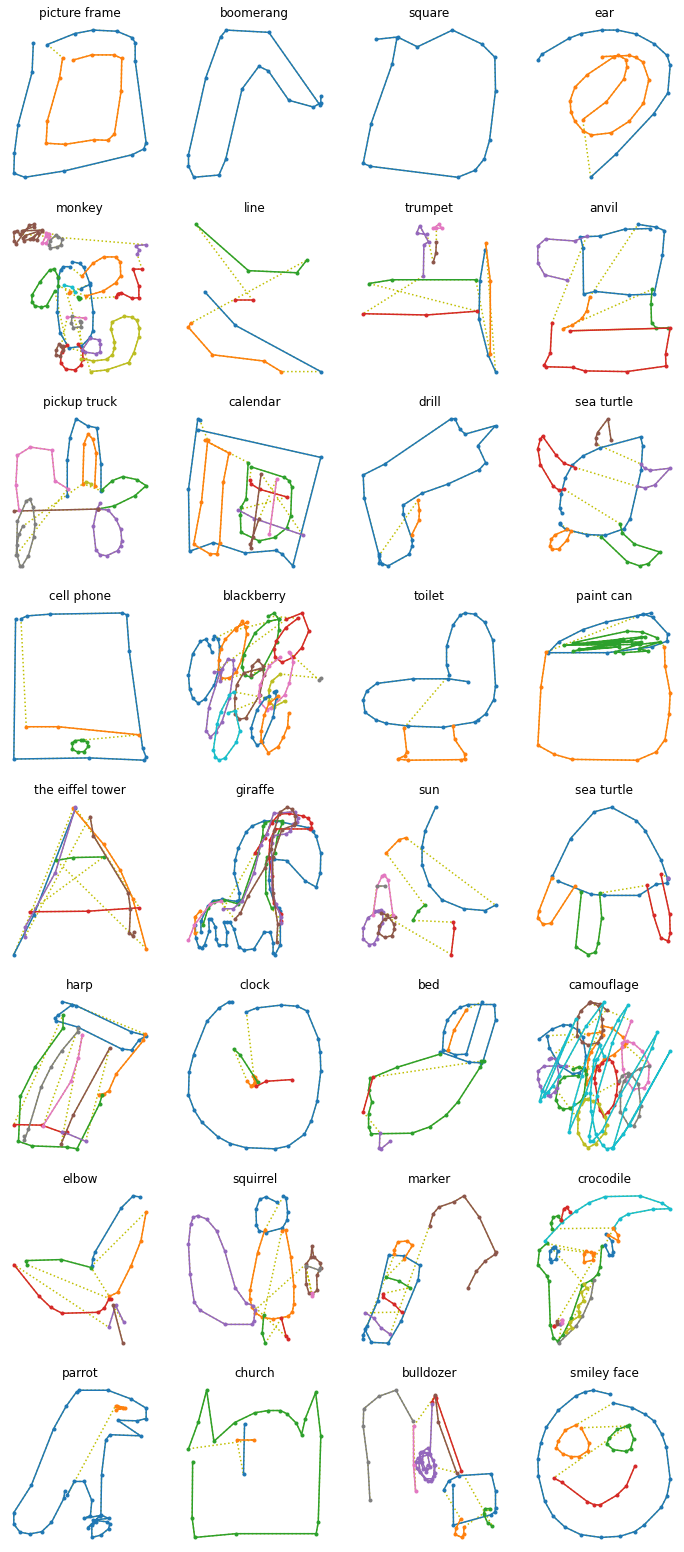

In [45]:
def draw_sketch(sketch, label=None):
    # Add the coordinate origin to the sketch
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    
    # Plot the coordinates
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    
    # Plot individual strokes
    stroke_end_indices = np.argwhere(sketch[:, -1] == 1.)[:, 0]
    for stroke in np.split(coordinates, stroke_end_indices + 1):
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    
    # Add some styling
    plt.axis("off")
    plt.title(class_names[label.numpy()] if label is not None else "Try to guess")

    
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    
    plt.show()
    

# Plot one batch of sketches
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

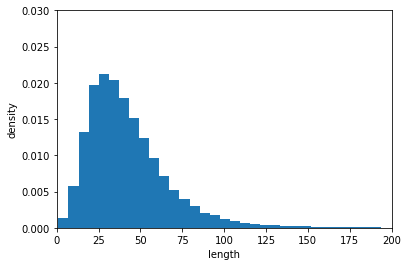

In [46]:
# Collect sketch lengts of 1k train samples
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])

# Show a histogram of sketch lengths
#  - notice: most sketches are composed of less than 100 points
plt.hist(lengths, bins=150, density=True)

plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")

plt.show()

In [47]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, _, labels: (inks[:, :max_length], labels))

# Edit the dataset by cropping long sketches
cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [48]:
# Build a model consisting of:
#  - initial set of three batch normalized 1D conv layers to sub-sample the inputs
#  - two LSTM recurrent layers (sequence-to-vector)
#  - final dense classification output layer
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])

optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", "sparse_top_k_categorical_accuracy"],
)

# Train and validate the model for few epochs
history = model.fit(cropped_train_set, epochs=2, validation_data=cropped_valid_set)

# Collect all test labels
y_test = np.concatenate([labels for _, _, labels in test_set])

# Run the test set through the model to get class probabilities
y_probas = model.predict(test_set)

# Evaluate the test set predictions
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

Epoch 1/2
107813/107813 [==============================] - 4733s 44ms/step - loss: 4.8450 - accuracy: 0.0826 - sparse_top_k_categorical_accuracy: 0.2083 - val_loss: 3.0758 - val_accuracy: 0.3093 - val_sparse_top_k_categorical_accuracy: 0.5951
Epoch 2/2
107813/107813 [==============================] - 3455s 32ms/step - loss: 2.8662 - accuracy: 0.3499 - sparse_top_k_categorical_accuracy: 0.6374 - val_loss: 2.5095 - val_accuracy: 0.4139 - val_sparse_top_k_categorical_accuracy: 0.7046


0.6046845

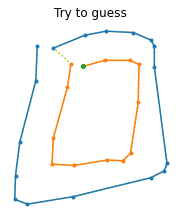

Top-5 predictions:
  1. paper clip 11.537%
  2. oven 9.015%
  3. cooler 6.948%
  4. washing machine 4.883%
  5. cell phone 4.638%
Answer: picture frame


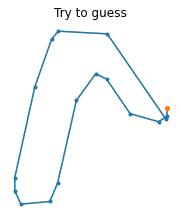

Top-5 predictions:
  1. squiggle 18.626%
  2. garden hose 12.178%
  3. rifle 8.297%
  4. moustache 7.407%
  5. bowtie 3.682%
Answer: boomerang


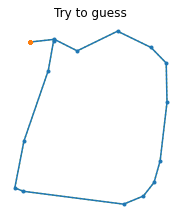

Top-5 predictions:
  1. hexagon 36.248%
  2. octagon 26.381%
  3. wine bottle 16.241%
  4. pear 1.196%
  5. pillow 1.094%
Answer: square


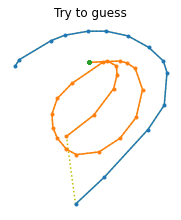

Top-5 predictions:
  1. ear 76.576%
  2. moon 12.482%
  3. boomerang 2.125%
  4. squiggle 1.309%
  5. paper clip 0.704%
Answer: ear


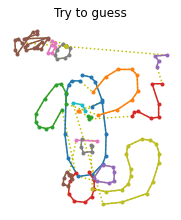

Top-5 predictions:
  1. monkey 30.416%
  2. lion 13.945%
  3. pig 8.537%
  4. teddy-bear 7.216%
  5. bear 4.556%
Answer: monkey


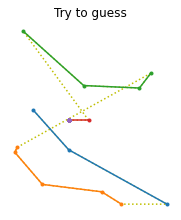

Top-5 predictions:
  1. floor lamp 9.949%
  2. octagon 8.341%
  3. hexagon 7.308%
  4. beach 4.823%
  5. chair 3.290%
Answer: line


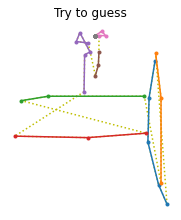

Top-5 predictions:
  1. syringe 9.891%
  2. train 7.161%
  3. sailboat 6.492%
  4. diving board 4.787%
  5. church 4.247%
Answer: trumpet


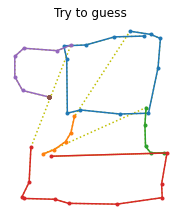

Top-5 predictions:
  1. shovel 14.960%
  2. lipstick 14.873%
  3. screwdriver 14.035%
  4. flying saucer 10.605%
  5. yoga 5.969%
Answer: anvil


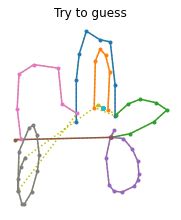

Top-5 predictions:
  1. headphones 45.454%
  2. eyeglasses 7.037%
  3. motorbike 6.394%
  4. tractor 4.600%
  5. pickup truck 3.492%
Answer: pickup truck


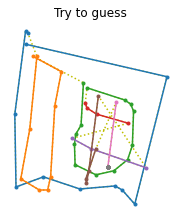

Top-5 predictions:
  1. yoga 18.880%
  2. belt 9.180%
  3. ant 7.132%
  4. fan 6.631%
  5. stereo 6.623%
Answer: calendar


In [49]:
n_new = 10

# Make a prediction on the batch of sketches we showed earlier and filter top 5 results
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)

for index in range(n_new):
    # Plot the sketch
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    
    # Show top 5 model predictions with probablities
    print("Top-5 predictions:")
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print(f"  {k + 1}. {class_name} {proba:.3f}%")
    
    # Show the actual class
    correct_class = class_names[labels[index].numpy()]
    print(f"Answer: {correct_class}")